# **Técnicas Avanzadas de Aprendizaje**

##Random Forest - Reconocimiento de números escritos a mano##

###Andrea Azábal Lamoso###

21 de junio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

# *Dataset*

Nuestro objetivo es implementar un modelo predictivo que nos permita encontrar patrones de reconocimiento de los dígitos contenidos en las imágenes del *dataset*. Para ello, disponemos de la siguiente información:

- X_train: array de 60.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de entrenamiento de 60.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_train: array de 60.000 filas, donde cada fila tiene el valor entero del dígito de la imagen. 
- X_test: array de 10.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de test de 10.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_test: array de 10.000 filas, donde cada fila tiene el valor entero del dígito de la imagen.




Importamos el conjunto de datos desde *TensorFlow*:

In [2]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Nos valemos de la función `reshape()` para almacenar una única línea (de 28x28=784 columnas) por cada imagen:

In [3]:
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


A continuación se ha representado una muestra de las categorías contenidas en el *dataset* con sus imágenes correspondientes:

In [5]:
y_u=pd.DataFrame(y_train).drop_duplicates()
X_u=x_train[y_u[0].sort_values().index]

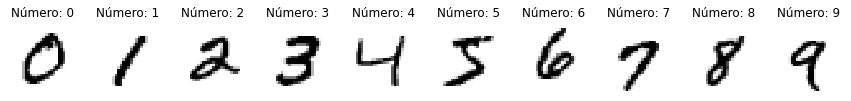

In [6]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u[0].sort_values()):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Número: %i' % label)

#*Random Forest*

En este tipo de algoritmo, se entrenan varios árboles de decisión en paralelo y se obtiene una predicción final calculada a partir de todas sus estimaciones. De esta forma se consigue reducir la variación y el *overfitting* del modelizado.

En concreto, los árboles de decisión toman muestras aleatorias con reemplazo del conjunto de datos original de manera que el número de filas seleccionado en cada AD será inferior al del conjunto total. Asimismo, también se toman variables aleatorias en uno de ellos. 

El resultado de cada árbol de decisión será una probabilidad de pertenecer a una determinada clase y la predicción final se obtendrá sumando las probabilidades devueltas por todos los AD, promediando y seleccionando la clase ganadora.

A la hora de implementar el algoritmo, es necesario tener en cuenta los siguientes parámetros:

-  **n_estimators**: es el número de árboles de decisión que se lanzan en paralelo. Cuanto mayor es su número, más robusto es el modelo contra *overfitting*. 

- **max_features**: el número de variables a usar en cada una de estas decisiones (*splits*). Por defecto se tiene $\sqrt{N}$ en clasificación (siendo $N$ el número total de variables predictoras).

- **max_depth**: indica la profundidad de los árboles de decisión. Cuanto más alto es este número, más sobreajuste existirá al subconjunto de entrenamiento. 

- **criterion**: se trata del tipo de fórmula de cálculo de "impureza" para modelos de clasificación (*Gini* o *Entropy*).

#Modelizados

En esta tarea, se van a utilizar algoritmos *Random Forest* para clasificar las imágenes contenidas en el *dataset*.

##$n=600$

En primer lugar, comenzamos con una muestra de 600 imágenes de dígitos para el entrenamiento del modelo:

In [7]:
n_train = 600 # digitos a usar en entrenamiento
x_train1=x_train[0:n_train]
y_train1=y_train[0:n_train]

Podemos comprobar qué porcentaje del total supone cada dígito:

In [8]:
pd.Series(y_train1).value_counts()/600

1    0.131667
9    0.108333
2    0.106667
7    0.103333
4    0.098333
3    0.098333
0    0.096667
6    0.090000
5    0.085000
8    0.081667
dtype: float64

Vemos que el número más abundante es el 1 en este *dataset* (13% de las observaciones), mientras que el menos repetido es el 8 (8%).

###Ejemplo

Para empezar, vamos a generar un *Random Forest* sencillo con los parámetros `max_depth=10` y `n_estimators=10`, es decir, con 10 niveles de profundidad y lanzando 10 árboles de decisión en paralelo.

In [9]:
from sklearn import metrics

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=10, n_estimators=10,random_state=0, n_jobs=5)
rf_model.fit(x_train1,y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
pred_train = rf_model.predict(x_train1)
pred_test = rf_model.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model.score(x_train1, y_train1)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model.score(x_test, y_test)))

Precisión sobre los datos de entrenamiento: 99.83
Precisión sobre los datos de test: 75.07


De esta forma, obtenemos una precisión sobre el subconjunto de entrenamiento próxima al 100%, mientras que esta se reduce a un 75% para el subconjunto de prueba, es decir, existe *overfitting* y el modelizado se está ajustando demasiado a los datos de entrenamiento.

Podemos representar algunas de las predicciones del algoritmo:

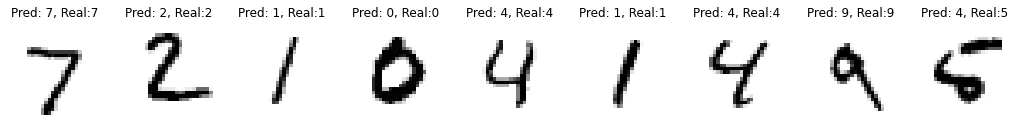

In [12]:
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(18, 18))
for ax, image, prediction, real in zip(axes, x_test, pred_test, y_test):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Pred: {prediction}, Real:{real}')

Vemos que, en este ejemplo, ha acertado la mayoría de imágenes excepto un 5 que ha clasificado como 4. 

A continuación, vamos a tratar de optimizar el modelo y reducir el *overfitting* seleccionando los parámetros *maxdepth* y *n_estimators* que mejores predicciones arrojen.

###Selección de *maxdepth*

Comenzamos seleccionando la profundidad máxima de los árboles de decisión. Para ello, calculamos la bondad del ajuste desde un único nivel hasta llegar a 20. Además, al no especificar el parámetro *n_estimators*, por defecto se están lanzando 100 AD en paralelo:

In [13]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,20)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=maxdepth, n_jobs=5)
  rf_model.fit(x_train1, y_train1)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(x_train1, y_train1))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

Representamos el *score* en función de la profundidad:

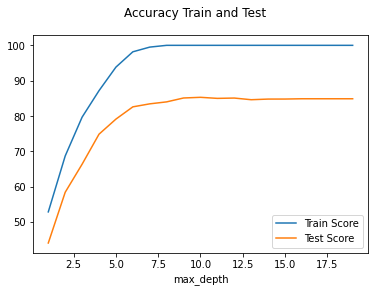

In [14]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

In [15]:
df[df.score_test==df.score_test.max()]

,score_train,score_test
max_depth,,
10,100.0,85.28


En la gráfica observamos *underfitting* para profundidades bajas de los árboles de decisión, ya que la *accuracy* es baja tanto para el subconjunto de entrenamiento como para el subconjunto de *test*. Esto tiene sentido, pues para pocos niveles los árboles de decisión no son capaces de tomar decisiones lo suficientemente complejas.

Vemos que el máximo para la *accuracy* sobre el subconjunto de *test* se obtiene con una profundidad de 10, por lo que fijamos ese parámetro:

In [16]:
rf_model_10 = RandomForestClassifier(max_depth=10, random_state=0, n_jobs=5)
rf_model_10.fit(x_train1,y_train1)
pred_train = rf_model_10.predict(x_train1)
pred_test = rf_model_10.predict(x_test)

Una profundidad superior a 10 estaría introduciendo una complejidad excesiva en los árboles de decisión, que conllevaría un mayor coste computacional sin suponer una mejora en las predicciones.

###Selección *n_estimators*

De manera similar, ahora vamos a determinar cuál es el número óptimo de árboles de decisión lanzados en paralelo. Para ello, vamos a fijar el parámetro `maxdepth=10` y vamos a probar con un rango entre 10 y 100 AD:

In [17]:
md_list = []
score_train_list = []
score_test_list = []

for nestimators in list(range(10,101,10)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=10, n_jobs=5, n_estimators=nestimators)
  rf_model.fit(x_train1, y_train1)

  ## Generación de listas
  md_list.append(nestimators)
  score_train_list.append(100.0*rf_model.score(x_train1, y_train1))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

Representamos la *accuracy* en función del número de árboles de decisión:

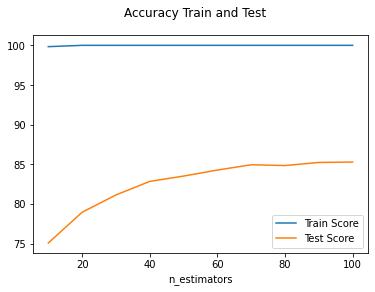

In [18]:
df = pd.DataFrame({"n_estimators":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

In [19]:
df[df.score_test==df.score_test.max()]

,score_train,score_test
n_estimators,,
100,100.0,85.28


Vemos que el número idóneo es el que se utiliza por defecto `n_estimator=100`, que es el mismo modelizado que habíamos concluido como óptimo en el apartado previo (`maxdepth=10`).

El hecho de aumentar excesivamente este parámetro `n_estimator=100` perjudica los tiempos de computación, pues han de calcularse más árboles en paralelo. A cambio, los modelos que utilizan varios AD a la vez son más robustos frente al *overfitting*, es decir, evitan que ocurran sobreajustes a los datos de entrenamiento, lo cual mejora las predicciones sobre el subconjunto *test*.

En particular, si comparamos el *score* de este modelo (85,28%) con el *score* del modelo de ejemplo que implementamos al comienzo (75,07%), vemos que se ha conseguido mejorar la precisión total sobre el subconjunto de prueba y hemos reducido considerablemente el *overfitting*.

###Evaluación del modelo

Una vez hemos seleccionado la mejor especificación del modelo, procedemos a evaluar los resultados sobre el subconjunto de prueba.

- **Matriz de confusión**:

En la matriz de confusión representamos los valores reales frente a las predicciones del modelo:

Confusion matrix:



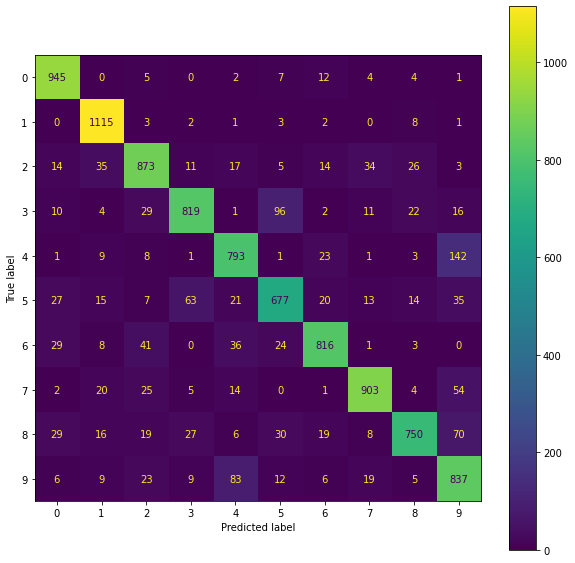

In [20]:
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(rf_model_10, x_test, y_test, cmap=plt.cm.viridis, ax=ax, values_format = '.0f')
plt.show()

Así, comprobamos que el algoritmo está funcionando bastante bien pues la mayoría de las observaciones están en la diagonal, es decir, ha predicho el valor correcto (verdaderos positivos). Los valores fuera de la diagonal indican falsos positivos si se encuentran a lo largo de la columna de la etiqueta predicha y falsos negativos si se encuentran a lo largo de la fila del valor real.

Si, por ejemplo, nos fijamos en el dígito 1, podemos obtener su *precision* y *recall* de la siguiente forma:

$$ Precision_1 =  \frac{TP}{TP+FP} = \frac{1115}{1115+35+4+9+15+8+20+16+9}=0.9058 $$ 

$$ Recall_1 =  \frac{TP}{TP+FN}=\frac{1115}{1115+3+2+1+3+2+8+1}=0.9824$$ 

Por tanto, para esta clase no se están generando muchos falsos negativos pues el *recall* es muy alto pero sí que se están dando algunos falsos positivos (*precision* más bajo aunque sigue siendo muy bueno).

-  ***Precision* y *recall***

Si obtenemos estos indicadores para todas las clases (gracias a `classification_report()`):

In [21]:
print(f"Classification report for classifier {rf_model_10}:\n"
      f"{metrics.classification_report(y_test, pred_test)}\n")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       980
           1       0.91      0.98      0.94      1135
           2       0.85      0.85      0.85      1032
           3       0.87      0.81      0.84      1010
           4       0.81      0.81      0.81       982
           5       0.79      0.76      0.78       892
           6       0.89      0.85      0.87 

Los dígitos que mejor se están clasificando por el algoritmo (atendiendo al *F1-Score*) son 0, 1 y 7. 

Por el contrario, los números 5 y 9 son los que peores resultados están dando. De hecho, si nos fijamos en la matriz de confusión representada, vemos que el número 5 se está clasificando erróneamente como un 3 en la mayoría de falsos negativos, lo cual hace que disminuya el *recall*. También se está clasificando erróneamente el dígito 3 como un 5, motivo por el cual aumentan los falsos positivos y, por tanto, disminuye la *precision*.

Por otra parte, en el caso del número 9, este se está clasificando mayoritariamente como un 4 en las predicciones erróneas (fuera de la diagonal), lo cual hace que disminuya el *recall* para esta clase, aunque su valor (0.83) no es del todo malo. La causa del bajo *F1-Score* la tiene la *precision*, debido a que hay muchos 4, 7 y 8 que se están clasificando como 9 (falsos positivos).

Concluimos así que el algoritmo tiene problemas principalmente a la hora de distinguir un 5 de un 3 y un 9 de un 4.

##$n=6000$

A continuación vamos a aumentar el número de dígitos para el entrenamiento hasta 6000:

In [22]:
n_train = 6000 # digitos a usar en entrenamiento
x_train2=x_train[0:n_train]
y_train2=y_train[0:n_train]

Podemos comprobar qué porcentaje del total supone cada dígito:

In [23]:
pd.Series(y_train2).value_counts()/6000

1    0.111833
7    0.108500
4    0.103833
3    0.101333
6    0.101333
9    0.100167
0    0.098667
2    0.096833
8    0.091833
5    0.085667
dtype: float64

Vemos que el número más abundante es el 1 en este *dataset* (11% de las observaciones), mientras que el menos repetido es el 5 (8.5%).

###Selección de *maxdepth*

De manera análoga al caso anterior, vamos a seleccionar el número óptimo de niveles de los árboles de decisión:

In [24]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,21)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=maxdepth, n_jobs=5)
  rf_model.fit(x_train2, y_train2)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(x_train2, y_train2))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

Si representamos la *accuracy* en función de la profundidad:

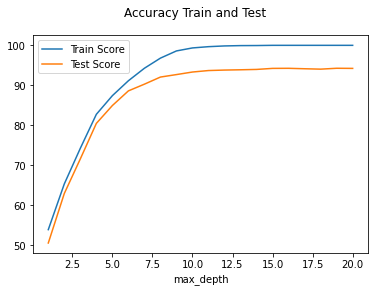

In [25]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

De nuevo, observamos *underfitting* para profundidades muy bajas. Asimismo, vemos que para 15 niveles de profundidad se llega a un máximo a partir del cual la precisión para el subconjunto de *test* comienza a oscilar, por lo que nos quedamos con `max_depth=15`. Una profundidad superior estaría introduciendo una complejidad excesiva en los árboles de decisión, que conllevaría un mayor coste computacional sin suponer una mejora en las predicciones.

In [26]:
rf_model_15 = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=5)
rf_model_15.fit(x_train2,y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [27]:
pred_train = rf_model_15.predict(x_train2)
pred_test = rf_model_15.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_15.score(x_train2, y_train2)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model_15.score(x_test, y_test)))

Precisión sobre los datos de entrenamiento: 100.00
Precisión sobre los datos de test: 94.23


En concreto, se tiene una *accuracy* del 94.23% para el subconjunto de *test*, muy superior a la que obtuvimos con únicamente 600 muestras.

###Selección *n_estimators*

Procedemos ahora a seleccionar el número óptimo de árboles de decisión lanzados en paralelo:

In [28]:
md_list = []
score_train_list = []
score_test_list = []

for nestimators in list(range(10,101,10)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=15, n_jobs=5, n_estimators=nestimators)
  rf_model.fit(x_train2, y_train2)

  ## Generación de listas
  md_list.append(nestimators)
  score_train_list.append(100.0*rf_model.score(x_train2, y_train2))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

Representando la *accuracy* en función del número de AD:

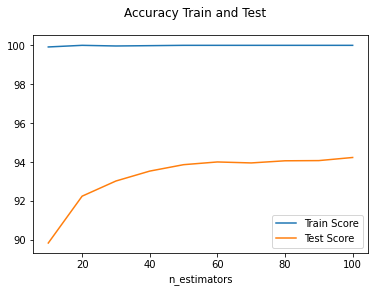

In [29]:
df = pd.DataFrame({"n_estimators":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Concluimos que el número óptimo es, de nuevo, `n_estimators=100`. Un número superior puede generar lentitud en la computación y un número muy reducido puede causar problemas de *overfitting* como ya hemos argumentado previamente.

Así, al aumentar el tamaño del *set* de entrenamiento hemos conseguido aumentar mucho la precisión del algoritmo sobre el subconjunto de *test*. Es lógico, pues al tener un mayor número de observaciones sobre las que entrenar, mejorarán las predicciones sobre nuevos conjuntos de datos.

###Evaluación del modelo

De nuevo, vamos a evaluar cómo está funcionando este último modelo a la hora de clasificar dígitos.

- **Matriz de confusión**:

Si representamos la matriz de confusión:

Confusion matrix:



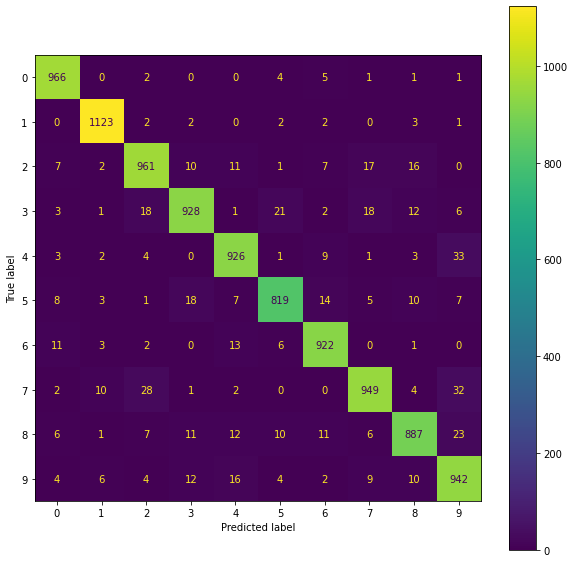

In [30]:
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(rf_model_15, x_test, y_test, cmap=plt.cm.viridis, ax=ax, values_format = '.0f')
plt.show()

Comprobamos que efectivamente hemos mejorado las clasificación en comparación con el subconjunto de 600 dígitos, pues ahora hay muchas menos observaciones fuera de la diagonal. 

Para obtener los valores exactos:

- ***Precision* y *recall***

In [31]:
print(f"Classification report for classifier {rf_model_15}:\n"
      f"{metrics.classification_report(y_test, pred_test)}\n")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.95      0.92      0.93      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.95      0.96      0.95 

Comprobamos que ahora ya no hay una diferencia tan drástica entre clases, sino que todas ellas tienen valores en un rango más reducido para todos los indicadores. En particular, destacan las clases 0 y 1 por sus buenos valores para el *precision* y el *recall*. Por otra parte, de nuevo la clase 9 es la que peor *precision* tiene y, si nos fijamos en la matriz, esto se debe a que el algoritmo sigue confundiendo mayoritariamente los números 4, 7 y 8 con el 9, es decir, está generando falsos positivos para la clase 9.

#Conclusiones

A lo largo de esta tarea se ha buscado modelizar un clasificador de imágenes que contienen dígitos mediante el algoritmo de *Random Forest*. Para ello, se han generado distintos modelos en los que se ha variado tanto el tamaño del conjunto de datos como los parámetros de la implementación referentes al número de árboles de decisión lanzados en paralelo y a la profundidad de los mismos.

En la siguiente tabla se resumen los modelos generados:

|      n     | *max_depth* |  *n_estimators*  |  *Accuracy (test)* |
|------------|:-----------:|:----------------:|:------------------:|
|   $600$    |      10     |          10      |       75.07%       |
|   $600$    |      10     |         100      |       85.28%       |
|   $6000$   |      15     |         100      |       94.23%       |

Como puede comprobarse, el hecho de aumentar el número de árboles de decisión que se lanzan en paralelo (de 10 a 100) mejora un 10% la *accuracy* del clasificador. Esto se debe a que con un mayor número de árboles de decisión se consigue reducir el *overfitting*, es decir, el modelo no se sobreajusta al subconjunto de entrenamiento y por tanto arroja mejores predicciones sobre el subconjunto de prueba.

Por otra parte, al aumentar el tamaño de la muestra hasta 6000 imágenes, también conseguimos aumentar la precisión global del modelo un 9%. En este segundo caso, además, la profundidad óptima aumenta desde 10 hasta 15 niveles, probablemente debido al aumento en la complejidad del cálculo al añadirse 10 veces más registros. De esta forma, al poder entrenar sobre un número mucho más amplio de observaciones, estamos generando árboles de decisión más complejos, razón por la que aumenta el *accuracy* sobre el subconjunto de *test*.

Si comparamos los resultados clase a clase entre los dos modelos "óptimos", esto es, los parametrizados como `n_estimators=100`, vemos lo siguiente:

|      Dígito     | *F1-Score* ($n=600$) | *F1-Score* ($n=6000$)|
|:---------------:|:--------------------:|:--------------------:|
|      $0$        |          93%         |         97%          |      
|      $1$        |          94%         |         98%          |       
|      $2$        |          85%         |         93%          |   
|      $3$        |          84%         |         93%          |      
|      $4$        |          81%         |         94%          |       
|      $5$        |          78%         |         93%          |  
|      $6$        |          87%         |         95%          |      
|      $7$        |          89%         |         93%          |       
|      $8$        |          83%         |         92%          | 
|      $9$        |          77%         |         92%          | 

Comprobamos que, efectivamente, el clasificador funciona mucho mejor cuando el conjunto de datos es más extenso ya que el *F1-Score* ha aumentado en todas las categorías. Asimismo, mientras que para $n=600$ existen categorías que funcionan mucho peor que otras (en concreto el 5 y el 9), esta diferencia disminuye mucho al aumentar $n$, de manera que en el segundo modelo se tienen unos *F1-Score* mucho menos dispares entre dígitos.

Se concluye, por tanto, que para mejorar la precisión del algoritmo es conveniente escoger un número lo suficientemente grande de árboles de decisión (para evitar *overfitting*) y una profundidad de los mismos acorde al tamaño del *dataset*. Así, cuanto mayor sea la muestra de datos de la que dispongamos, mejores predicciones arrojará el clasificador. Sin embargo, no es conveniente excederse demasiado pues la ejecución puede volverse costosa, tanto si se tiene un $n$ muy grande como si se escoge un alto número de árboles de decisión lanzados en paralelo.
    